# dislocation_SDVPN calculation style

**Lucas M. Hale**, [lucas.hale@nist.gov](mailto:lucas.hale@nist.gov?Subject=ipr-demo), *Materials Science and Engineering Division, NIST*.

Description updated: 2019-07-26

## Introduction

The dislocation_SDVPN calculation style predicts a dislocation's planar spreading using the semidiscrete variational Peierls-Nabarro method.  The solution finds the disregistry (difference in displacement above and below the slip plane) that minimizes the dislocation's energy.  The energy term consists of two primary components: an elastic component due to the dislocation interacting with itself, and a misfit component arising from the formation of a generalized stacking fault along the dislocation's spreading.

### Version notes

### Additional dependencies

### Disclaimers

- [NIST disclaimers](http://www.nist.gov/public_affairs/disclaimer.cfm)
- The calculation method solves the problem using a 2D generalized stacking fault energy map.  Better results may be possible by measuring a full 3D map, but that would require adding a new calculation for the 3D variation.
- The implemented method is suited for dislocations with planar spreading. It is not suited for dislocations that spread on multiple atomic planes, like the a/2<111> bcc screw dislocation.
- While the solution is taken at discrete points that (typically) correspond to atomic sites, the underlying method is still a continuum solution that does not fully account for the atomic nature of the dislocation.


## Method and Theory

This calculation method is a wrapper around the atomman.defect.SDVPN class.  More details on the method and theory can be found in the [associated tutorial within the atomman documentation](https://www.ctcms.nist.gov/potentials/atomman/tutorial/04.4._Semidiscrete_Variational_Peierls-Nabarro.html).


## Demonstration

### 1. Setup

#### 1.1. Library imports

Import libraries needed by the calculation. The external libraries used are:

- [numpy](http://www.numpy.org/)

- [scipy](https://scipy.org/scipylib/)

- [matplotlib](https://matplotlib.org/)

- [DataModelDict](https://github.com/usnistgov/DataModelDict)

- [atomman](https://github.com/usnistgov/atomman)

- [iprPy](https://github.com/usnistgov/iprPy)

In [1]:
# Standard library imports
from pathlib import Path
import os
import sys
import uuid
import shutil
import random
import datetime
from copy import deepcopy

# http://www.numpy.org/
import numpy as np 

# https://matplotlib.org/
import matplotlib.pyplot as plt
%matplotlib inline

# https://github.com/usnistgov/DataModelDict 
from DataModelDict import DataModelDict as DM

# https://github.com/usnistgov/atomman 
import atomman as am
import atomman.lammps as lmp
import atomman.unitconvert as uc

# https://github.com/usnistgov/iprPy
import iprPy

print('Notebook last executed on', datetime.date.today(), 'using iprPy version', iprPy.__version__)

Notebook last executed on 2019-07-29 using iprPy version 0.9.0


#### 1.2. Default calculation setup

In [2]:
# Specify calculation style
calc_style = 'dislocation_SDVPN'

# If workingdir is already set, then do nothing (already in correct folder)
try:
    workingdir = workingdir

# Change to workingdir if not already there
except:
    workingdir = Path('calculationfiles', calc_style)
    if not workingdir.is_dir():
        workingdir.mkdir(parents=True)
    os.chdir(workingdir)

### 2. Assign values for the calculation's run parameters

#### 2.1. Load initial unit cell system

- __prototype_name__ gives the name of the crystal_prototype reference record in the iprPy library to load. 

- __symbols__ is a list of the potential's elemental model symbols to associate with the unique atom types of the loaded system. 

- __box_parameters__ is a list of the a, b, c lattice constants to assign to the loaded file.

- __load_file__ gives the path to the atomic configuration file to load for the ucell system.  Here, this is generated automatically using prototype_name and librarydir.

- __load_style__ specifies the format of load_file.  Here, this is automatically set for crystal_prototype records.

- __load_options__ specifies any other keyword options for properly loading the load_file.  Here, this is automatically set for crystal_prototype records.

- __ucell__ is an atomman.System representing a fundamental unit cell of the system (required).  Here, this is generated using the load parameters and symbols.

In [3]:
prototype_name = 'A1--Cu--fcc'
symbols = ['Ni']
box_parameters = uc.set_in_units([3.52, 3.52, 3.52], 'angstrom')

# Define load_file using librarydir and prototype_name
load_file = Path(iprPy.libdir, 'crystal_prototype', f'{prototype_name}.json')

# Define load_style and load_options for crystal_prototype records
load_style = 'system_model'
load_options = {}

# Create ucell by loading prototype record
ucell = am.load(load_style, load_file, symbols=symbols, **load_options)

# Rescale ucell using box_parameters
ucell.box_set(a=box_parameters[0], b=box_parameters[1], c=box_parameters[2], scale=True)

print(ucell)

avect =  [ 3.520,  0.000,  0.000]
bvect =  [ 0.000,  3.520,  0.000]
cvect =  [ 0.000,  0.000,  3.520]
origin = [ 0.000,  0.000,  0.000]
natoms = 4
natypes = 1
symbols = ('Ni',)
pbc = [ True  True  True]
per-atom properties = ['atype', 'pos']
     id |   atype |  pos[0] |  pos[1] |  pos[2]
      0 |       1 |   0.000 |   0.000 |   0.000
      1 |       1 |   0.000 |   1.760 |   1.760
      2 |       1 |   1.760 |   0.000 |   1.760
      3 |       1 |   1.760 |   1.760 |   0.000


#### 2.2 Specify material elastic constants

Simple input parameters:

- __C_dict__ is a dictionary containing the unique elastic constants for the potential and crystal structure defined above. 

Derived parameters

- __C__ is an atomman.ElasticConstants object built from C_dict.

In [4]:
C_dict = {}
C_dict['C11'] = uc.set_in_units(247.86, 'GPa')
C_dict['C12'] = uc.set_in_units(147.83, 'GPa')
C_dict['C44'] = uc.set_in_units(124.84, 'GPa')

# -------------- Derived parameters -------------- #
# Build ElasticConstants object from C_dict terms
C = am.ElasticConstants(**C_dict)

#### 2.3 Specify the defect parameters

- __gammasurface_file__ gives the path to a data model file containing 2D gamma surface results.  This can be a calc_stacking_fault_map_2D record.

- __dislocation_name__ gives the name of the dislocation_monopole reference record in the iprPy library to use for potential. 

- __dislocation_file__ gives the path to a dislocation_monopole reference containing defect input parameters. Here, this is built automatically using dislocation_name and librarydir.

- __dislocation_kwargs__ is a dictionary containing parameters for generating the defect. Values are extracted from the dislocation_model record and uniquely define a type of stacking fault. Included keywords are:

    - __burgers__ is the crystallographic Burgers vector for the dislocation
    
    - __a_uvw, b_uvw, c_uvw__ specifies how to orient the system by defining the crystal vectors of ucell to place along the three system box vectors.
    
    - __atomshift__ is a 3D vector rigid-body shift to apply to atoms in the system. The atomshift vector is relative to the rotated unit cell's box vectors.
    
    - __stroh_m__ a Cartesian unit vector used by the Stroh method to define the created dislocation's orientation and type. This vector is in the dislocation's slip plane and perpendicular to the dislocation's line direction. Default value is \[0, 1, 0\], i.e. along the y-axis. 
    
    - __stroh_n__ a Cartesian unit vector used by the Stroh method to define the created dislocation's orientation and type. This vector is normal to the dislocation's slip plane. Default value is \[0, 0, 1\], i.e. along the z-axis.
    
    - __lineboxvector__ the system box vector, 'a', 'b', or 'c', along which the dislocation line is placed parallel to. Default value is 'a'.

In [5]:
gammasurface_file = '../stacking_fault_map_2D/gamma.json'

#dislocation_name = 'A1--Cu--fcc--a-2-110--0-screw--{111}'
#dislocation_name = 'A1--Cu--fcc--a-2-110--90-edge--{100}'
dislocation_name = 'A1--Cu--fcc--a-2-110--90-edge--{111}'

# Define dislocation_fi;e using librarydir and dislocation_name
dislocation_file = Path(iprPy.libdir, 'dislocation', f'{dislocation_name}.json')

# Create dictionary of input parameters related to the defect
inputs = {'ucell':ucell, 'dislocation_file':dislocation_file, 'gammasurface_file': gammasurface_file}

# Call input interpret functions
iprPy.input.subset('dislocation').interpret(inputs)
iprPy.input.subset('atomman_systemmanipulate').interpret(inputs)
iprPy.input.subset('atomman_gammasurface').interpret(inputs)

axes = inputs['transformationmatrix']

# Show inputs
inputs

{'ucell': <atomman.core.System.System at 0x2640f52f748>,
 'dislocation_file': WindowsPath('c:/users/lmh1/documents/python-packages/iprpy/library/dislocation/A1--Cu--fcc--a-2-110--90-edge--{111}.json'),
 'gammasurface_file': '../stacking_fault_map_2D/gamma.json',
 'dislocation_family': 'A1--Cu--fcc',
 'dislocation_stroh_m': '0 1 0',
 'dislocation_stroh_n': '0 0 1',
 'dislocation_lineboxvector': 'a',
 'a_uvw': '-1 -1  2',
 'b_uvw': ' 1 -1  0',
 'c_uvw': ' 1  1  1',
 'atomshift': ' 0.00 0.00 0.5',
 'dislocation_burgersvector': ' 0.5 -0.5  0.0',
 'dislocation_model': DataModelDict([('key',
                 'd59f2382-17e5-4fbd-b398-407c75e6009a'),
                ('id', 'A1--Cu--fcc--a-2-110--90-edge--{111}'),
                ('character', 'edge'),
                ('Burgers-vector', 'a/2[ 1,-1, 0]'),
                ('slip-plane', [1, 1, 1]),
                ('line-direction', [-1, -1, 2]),
                ('system-family', 'A1--Cu--fcc'),
                ('calculation-parameter',
         

#### 2.4 Specify calculation-specific run parameters

- __xmax__: The maximum value of the x-coordinates to use for the points where the disregistry is evaluated.  The solution is centered around x=0, therefore this also corresponds to the minimum value of x used.  The set of x-coordinates used is fully defined by giving at least two of xmax, xstep and xnum.

- __xstep__: The step size (delta x) value between the x-coordinates used to evaluate the disregistry.  The set of x-coordinates used is fully defined by giving at least two of xmax, xstep and xnum.

- __xnum__: The total number of x-coordinates at which to evaluate the disregistry.  The set of x-coordinates used is fully defined by giving at least two of xmax, xstep and xnum.

- __minimize_style__: The scipy.optimize.minimize method style to use when solving for the disregistry.  Default value is 'Powell', which seems to do decently well for this problem.

- __minimize_options__: Allows for the specification of the options dictionary used by scipy.optimize.minimize. This is given as "key value key value...".

- __minimize_cycles__: Specifies the number of times to run the minimization in succession.  The minimization algorithms used by the underlying scipy code often benefit from restarting and rerunning the minimized configuration to achive a better fit.  Default value is 10.

- __cutofflongrange__: The radial cutoff (in distance units) to use for the long-range elastic energy.  The long-range elastic energy is configuration-independent, so this value changes the dislocation's energy but not the computed disregistry profile. Default value is 1000 Angstroms.

- __tau_xy__: Shear stress (in units of pressure) to apply to the system. Default value is 0 GPa.

- __tau_yy__: Normal stress (in units of pressure) to apply to the system. Default value is 0 GPa.

- __tau_yz__: Shear stress (in units of pressure) to apply to the system. Default value is 0 GPa.

- __alpha__: Coefficient(s) (in pressure/length units) of the non-local energy correction term to use.  Default value is 0.0, meaning this correction is not applied.

- __beta_xx, beta_yy, beta_zz, beta_xy, beta_xz, beta_yz__: Components of the surface energy coefficient tensor (in units pressure-length) to use. Default value is 0.0 GPa-Angstrom for all, meaning this correction is not applied.

- __cdiffelastic, cdiffsurface, cdiffstress__: Booleans indicating how the dislocation density (derivative of disregistry) is computed within the elastic, surface and stress terms, respectively. If True, central difference is used, otherwise only the change between the current and previous points is used. Default values are True for cdiffsurface, and False for the other two.

- __halfwidth__: The arctan disregistry halfwidth (in length units) to use for creating the initial disregistry guess.

- __normalizedisreg__: Boolean indicating how the disregistry profile is handled.  If True (default), the disregistry is scaled such that the minimum x value has a disregistry of 0 and the maximum x value has a disregistry equal to the dislocation's Burgers vector.  Note that the disregistry for these endpoints is fixed, so if you use False the initial disregistry should be close to the final solution.

- __fullstress__: Boolean indicating which of two stress formulas to use.  True uses the original full formulation, while False uses a newer, simpler representation.  Default value is True.

In [6]:
xmax = None
xstep = 1/5
xnum = 200

minimize_style = 'Powell'
minimize_options = {}
minimize_options['disp'] = True # will display convergence info
minimize_options['xtol'] = 1e-6 # smaller convergence tolerance than default
minimize_options['ftol'] = 1e-6 # smaller convergence tolerance than default
#minimize_options['maxiter'] = 2 # for testing purposes
minimize_numcycles = 10

cutofflongrange = uc.set_in_units(1000, 'angstrom')
halfwidth = uc.set_in_units(5, 'angstrom')

### 3. Define calculation function(s)

#### 3.1. peierlsnabarro()

In [7]:
def peierlsnabarro(alat, C, axes, burgers, gamma, m=[0,1,0], n=[0,0,1],
                   cutofflongrange=uc.set_in_units(1000, 'angstrom'),
                   tau=np.zeros((3,3)), alpha=[0.0], beta=np.zeros((3,3)),
                   cdiffelastic=False, cdiffsurface=True, cdiffstress=False,
                   fullstress=True,
                   halfwidth=uc.set_in_units(1, 'angstrom'),
                   normalizedisreg=True,
                   xnum=None, xmax=None, xstep=None,
                   min_method='Powell', min_options={}, min_cycles=10):
    """
    Solves a Peierls-Nabarro dislocation model.
    """

    # Solve Stroh method for dislocation
    stroh = am.defect.Stroh(C, burgers, axes=axes, m=m, n=n)
    Kij = stroh.K_tensor

    # Transform burgers to axes
    T = am.tools.axes_check(axes)
    b = T.dot(burgers)

    # Transform b, axes and Kij to PN solution orientation
    mnu = np.array([m, n, np.cross(m, n)])
    axes = mnu.dot(axes)
    Kij = mnu.dot(Kij).dot(mnu.T)    
    b = mnu.dot(b)

    # Scale xmax and xstep by alat
    if xmax is not None:
        xmax *= alat
    if xstep is not None:
        xstep *= alat
    
    # Generate initial disregistry guess
    x, idisreg = am.defect.pn_arctan_disregistry(xmax=xmax, xstep=xstep, xnum=xnum,
                                                 burgers=b, halfwidth=halfwidth,
                                                 normalize=normalizedisreg)
    
    # Minimize disregistry
    cycle = 1
    pnsolution = am.defect.SDVPN(x, idisreg, gamma, axes, Kij,
                                tau=tau, alpha=alpha, beta=beta,
                                cutofflongrange=cutofflongrange,
                                burgers=b,
                                fullstress=fullstress,
                                cdiffelastic=cdiffelastic,
                                cdiffsurface=cdiffsurface,
                                cdiffstress=cdiffstress,
                                min_method=min_method,
                                min_options=min_options)

    # Retrieve initial and first minimization solution energies
    minimization_energies = []
    minimization_energies.append(pnsolution.total_energy(x, idisreg))
    minimization_energies.append(pnsolution.total_energy())

    # Repeat minimize if min_cycles > 1
    while cycle < min_cycles:
        cycle += 1
        pnsolution.solve()
        minimization_energies.append(pnsolution.total_energy())

    # Initialize results dict
    results_dict = {}
    results_dict['SDVPN_solution'] = pnsolution
    results_dict['minimization_energies'] = minimization_energies
    
    return results_dict



### 4. Run calculation function(s)

In [8]:
results_dict = peierlsnabarro(ucell.box.a, C, axes, inputs['burgersvector'], inputs['gamma'],
                              m = inputs['stroh_m'],
                              n = inputs['stroh_n'],
                              cutofflongrange = cutofflongrange,
                              #tau = tau,    
                              #alpha = alpha,
                              #beta = beta,
                              #cdiffelastic = cdiffelastic,
                              #cdiffsurface = cdiffsurface,
                              #cdiffstress = cdiffstress,
                              #fullstress = fullstress,
                              halfwidth = halfwidth,
                              #normalizedisreg = normalizedisreg,
                              xnum = xnum,
                              xstep = xstep,
                              xmax = xmax,
                              min_method = minimize_style,
                              min_options = minimize_options,
                              min_cycles = minimize_numcycles)

Optimization terminated successfully.
         Current function value: 4.901809
         Iterations: 26
         Function evaluations: 217844
Optimization terminated successfully.
         Current function value: 4.901803
         Iterations: 2
         Function evaluations: 18896
Optimization terminated successfully.
         Current function value: 4.901803
         Iterations: 1
         Function evaluations: 9596
Optimization terminated successfully.
         Current function value: 4.901802
         Iterations: 1
         Function evaluations: 9641
Optimization terminated successfully.
         Current function value: 4.901801
         Iterations: 1
         Function evaluations: 9669
Optimization terminated successfully.
         Current function value: 4.901801
         Iterations: 1
         Function evaluations: 9704
Optimization terminated successfully.
         Current function value: 4.901800
         Iterations: 1
         Function evaluations: 9716
Optimization terminated

In [9]:
results_dict.keys()

dict_keys(['SDVPN_solution', 'minimization_energies'])

### 5. Report results

#### 5.1 Define units for outputting values

- __length_unit__ is the unit of length to display results in.
- __energy_per_length_unit__ is the unit of energy per length to display dislocation energies in.

In [10]:
length_unit = 'angstrom'
energy_per_length_unit = 'eV/angstrom'

#### 5.2 Solution

SDVPN_solution in the results dictionary is an am.Defect.SDVPN object which contains the final disregistry information.

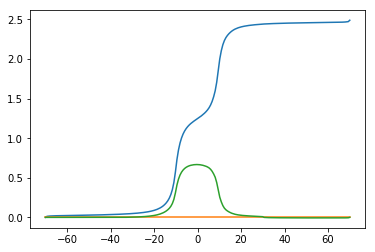

In [11]:
x = uc.get_in_units(results_dict['SDVPN_solution'].x, length_unit)
disreg = uc.get_in_units(results_dict['SDVPN_solution'].disregistry, length_unit)

plt.plot(x, disreg)
plt.show()

#### 5.3 Minimum energy per cycle

minimization_energies in the results dict lists the total computed dislocation energy for the initial disregistry and after each minimization run.

In [12]:
print('Total dislocation energy per minimization run (in %s):' % energy_per_length_unit)
for i, E_total in enumerate(results_dict['minimization_energies']):
    print(i, uc.get_in_units(E_total, energy_per_length_unit))

Total dislocation energy per minimization run (in eV/angstrom):
0 5.34326030380173
1 4.901808994668462
2 4.9018030878423104
3 4.901802508922141
4 4.901801986506575
5 4.901801475412439
6 4.901800965540583
7 4.901800454978468
8 4.901799943550891
9 4.901799431237917
10 4.901798917856279
